In [16]:
import pandas as pd

# Dependencies
from bs4 import BeautifulSoup
import requests

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [28]:
import pymongo   

conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
db = client.quotes
collection = db.quotes
collection.delete_many({})
collection.insert_many(all_quotes)

In [33]:
quotes_mongo = list(collection.find())

In [43]:
all_author = []
for quote in quotes_mongo:
    author = {'author_name': quote['authorName'], 
             'born': quote['author']['born'],
             'description':quote['author']['description']}
    all_author.append(author)
all_author_df = pd.DataFrame(all_author)
len(all_author_df)
all_unique_authors_df = all_author_df.drop_duplicates()
len(all_unique_authors_df)

50

In [36]:
quote = quotes_mongo[0]
quote

{'_id': ObjectId('60541152446f96d7cc1c305a'),
 'authorName': 'Albert Einstein',
 'quoteText': '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
 'about': 'https://quotes.toscrape.com//author/Albert-Einstein',
 'tags': ['change', 'deep-thoughts', 'thinking', 'world'],
 'author': {'born': 'March 14, 1879',
  'name': 'Albert Einstein',
  'description': 'In 1879, Albert Einstein was born in Ulm, Germany. He completed his Ph.D. at the University of Zurich by 1909. His 1905 paper explaining the photoelectric effect, the basis of electronics, earned him the Nobel Prize in 1921. His first paper on Special Relativity Theory, also published in 1905, changed the world. After the rise of the Nazi party, Einstein made Princeton his permanent home, becoming a U.S. citizen in 1940. Einstein, a pacifist during World War I, stayed a firm proponent of social justice and responsibility. He chaired the Emergency Committee of Atomic Scien

In [20]:
def get_author(url):
    result = {}
    response = requests.get(url)
    soup =  BeautifulSoup(response.text, 'lxml')    
    result['born'] = soup.find('span' , class_ = 'author-born-date').text.strip()
    result['name'] = soup.h3.text.strip()
    result['description'] = soup.find('div' , class_="author-description").text.strip()
    return result

In [21]:
# URL of page to be scraped
url = 'https://quotes.toscrape.com/'

In [22]:
#NEED IT DONT DELETE
def quote_data(quotes_data):
    # Collect the quote
    quoteText=quotes_data.span.text
    
    # Collect the author name
    authorName=quotes_data.small.text
    
    # Collect author link
    url_about=quotes_data.a['href']
    author_link =url+url_about
    author_data = get_author(author_link)
    # Collect tags
    #tag_container = quotes_data.find('div', {'class': 'tags'})
    tag_container = quotes_data.find('div', class_= 'tags')

    tag_links = tag_container.find_all('a')

    tags = []
    for tag in tag_links:
        tags.append(tag.text)
       
    # Return data as a dictionary
    return {'authorName': authorName,
            'quoteText': quoteText,
            'about': author_link,
            'tags': tags,
            'author': author_data}


In [23]:
def scrape_page(quotes_data):
    data = []
    for div in quotes_data:
        div_data = quote_data(div)
        data.append(div_data)
        
    return data

In [24]:
#NEED IT
def scrape_quotes(url):
    #print(url)
    base_url = 'http://quotes.toscrape.com'
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    quotes_data = soup.find_all('div', {'class': 'quote'})
    data = scrape_page(quotes_data)
    
    pager = soup.find('ul', {'class': 'pager'})
    if pager:
        next_page = pager.find('li', {'class': 'next'})
        
    if next_page:
        next_page =  next_page.findChild('a')\
                              .attrs\
                              .get('href')

        next_page = base_url + next_page
        print('Scraping', next_page)
        ## This is where the recursion happens
     #   data.extend (scrape_quotes(next_page))
        data+= scrape_quotes(next_page)
    

    return data

In [25]:
all_quotes = scrape_quotes(url)

Scraping http://quotes.toscrape.com/page/2/
Scraping http://quotes.toscrape.com/page/3/
Scraping http://quotes.toscrape.com/page/4/
Scraping http://quotes.toscrape.com/page/5/
Scraping http://quotes.toscrape.com/page/6/
Scraping http://quotes.toscrape.com/page/7/
Scraping http://quotes.toscrape.com/page/8/
Scraping http://quotes.toscrape.com/page/9/
Scraping http://quotes.toscrape.com/page/10/


In [26]:
print(len(all_quotes), 'Quotes scraped!')

100 Quotes scraped!


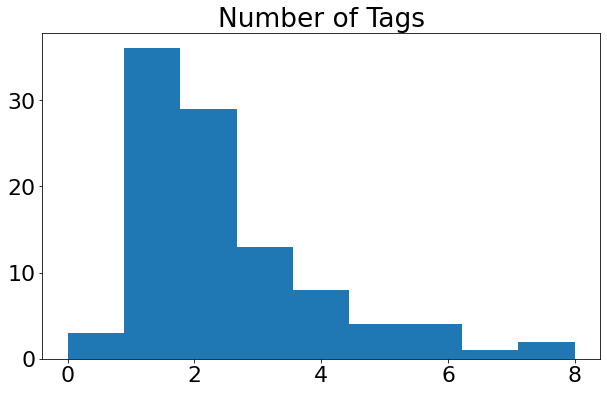

In [27]:
def count_tags(quote):
    return len(quote['tags'])

def tag_lengths(data):
    lengths = []
    for quote in data:
        lengths.append(count_tags(quote))
        
    return lengths
        
lengths = tag_lengths(all_quotes)
plt.figure(figsize=(10,6))   
plt.hist(lengths, bins=9)
plt.title('Number of Tags');